In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels
from scipy import stats
from tabulate import tabulate

# Тест Дики Фуллера

In [162]:
source = pd.read_csv('data/nonst.csv')
X = source["pwi"].dropna()
X

0        1.000000
1        3.650000
2        5.183000
3        6.426920
4        7.455227
         ...     
73    4923.938000
74    4952.902000
75    4949.282000
76    4934.800000
77    4891.353000
Name: pwi, Length: 78, dtype: float64

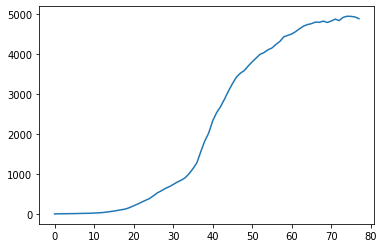

In [163]:
plt.plot(X)

In [164]:
result = adfuller(X, maxlag=None, regression='ct', autolag='t-stat', store=False, regresults=True)
result[3].__dict__['resols'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     13.61
Date:                Wed, 31 Mar 2021   Prob (F-statistic):           1.70e-12
Time:                        18:04:54   Log-Likelihood:                -319.46
No. Observations:                  65   AIC:                             668.9
Df Residuals:                      50   BIC:                             701.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0376      0.016     -2.416      0.019      -0.069      -0.006
x2             0.5286      0.133      3.987      0.000       0.262       0.795
x3             0.2051      0.153      1.336      0.187      -0.103       0.513
x4             0.3008      0.156      1.930      0.059      -0.012       0.614
x5            -0.2232      0.161     -1.384      0.172      -0.547       0.101
x6             0.1496      0.170      0.879      0.383      -0.192       0.491
x7            -0.0062      0.179     -0.035      0.972      -0.366       0.354
x8             0.0715      0.180      0.397      0.693      -0.290       0.433
x9            -0.0929      0.182     -0.510      0.613      -0.459       0.273
x10           -0.0356      0.184     -0.194      0.847      -0.405       0.334
x11           -0.0748      0.181     -0.414      0.681      -0.438       0.289
x12           -0.0759      0.185     -0.411      0.683      -0.447       0.295
x13            0.3643      0.157      2.318      0.025       0.049       0.680
const         -5.8366     15.285     -0.382      0.704     -36.537      24.864
x14            2.9081      1.433      2.030      0.048       0.030       5.786
==============================================================================
Omnibus:                       11.802   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.075
Skew:                           0.830   Prob(JB):                      0.00145
Kurtosis:                       4.440   Cond. No.                     1.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [165]:
result

(-2.4158001822022688,
 0.3712531830982635,
 {'1%': -4.105265484751935,
  '5%': -3.4803385352753753,
  '10%': -3.1678389485662266},
 <statsmodels.stats.diagnostic.ResultsStore at 0x7f97df410a20>)

# Сезонные модели

In [166]:
dist = pd.read_csv('data/season.csv')
season = dist["liquor"].dropna()
season

0       480
1       467
2       514
3       505
4       534
       ... 
331    1776
332    1743
333    1728
334    1769
335    2431
Name: liquor, Length: 336, dtype: int64

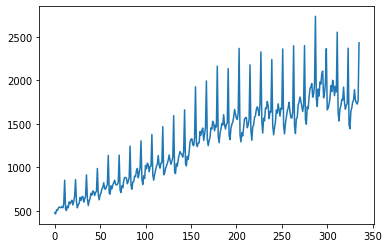

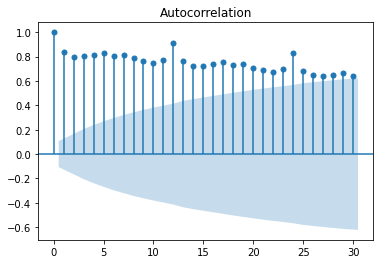

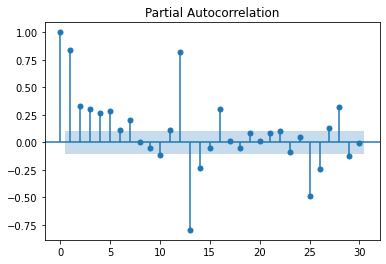

In [167]:
lagCount=30
plt.plot(season)
_ = plot_acf(season, lags=lagCount)
_ = plot_pacf(season, lags=lagCount)

In [168]:
pSeason = [0, 1, 2]#, 3, 4, 5, 6, 7, 8, 9, 10, 11]
qSeason = [0, 1, 2]#, 3, 4, 6, 11]

# Удаление тренда

In [169]:
diff = list()
for i in range(1, len(season)):
	value = season[i] - season[i - 1]
	diff.append(value)

In [170]:
# plt.plot(Y, label='season')
# plt.plot(diff, label='not trend')
# plt.show()

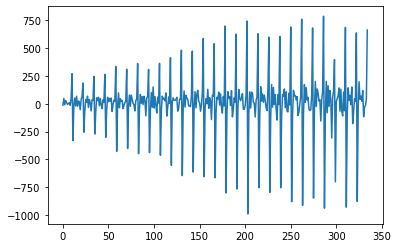

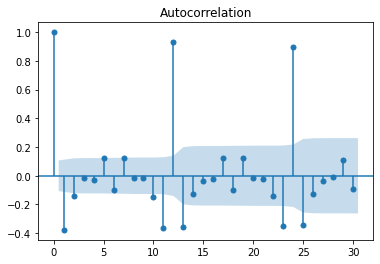

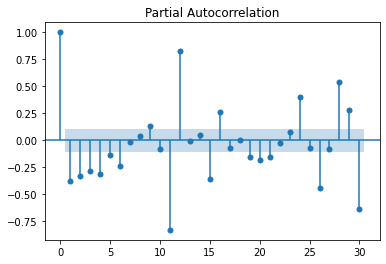

In [171]:
lagCountDiff = 30
plt.plot(diff)
_ = plot_acf(diff, lags=lagCountDiff)
_ = plot_pacf(diff, lags=lagCountDiff)

In [172]:
arr = np.array(season)
arr.size

336

In [174]:
from itertools import product
pOrder = [0, 1, 2]#, 11]
qOrder = [0, 1, 2]#, 3, 4, 5, 6, 11]
models = {}
for i,j,k,l in product(pOrder, qOrder, pSeason, qSeason):
    print(f'i: {i}| j: {j}| k: {k}| l: {l}')
    if ((i, j) == (0, 0)):
        continue
    arimax = SARIMAX(np.array(diff), order=(i, 0, j), seasonal_order=(k, 0, l, 12)).fit()
    pVal = arimax.pvalues
    if all(i <= 0.05 for i in pVal):
        models[i, j] = arimax
        print(f'{arimax.summary()}')
print(f'{models.keys()}')

i: 0| j: 0| k: 0| l: 0
i: 0| j: 0| k: 0| l: 1
i: 0| j: 0| k: 0| l: 2
i: 0| j: 0| k: 1| l: 0
i: 0| j: 0| k: 1| l: 1
i: 0| j: 0| k: 1| l: 2
i: 0| j: 0| k: 2| l: 0
i: 0| j: 0| k: 2| l: 1
i: 0| j: 0| k: 2| l: 2
i: 0| j: 1| k: 0| l: 0
i: 0| j: 1| k: 0| l: 1
i: 0| j: 1| k: 0| l: 2
i: 0| j: 1| k: 1| l: 0
i: 0| j: 1| k: 1| l: 1
i: 0| j: 1| k: 1| l: 2
i: 0| j: 1| k: 2| l: 0
i: 0| j: 1| k: 2| l: 1
i: 0| j: 1| k: 2| l: 2
i: 0| j: 2| k: 0| l: 0
i: 0| j: 2| k: 0| l: 1
i: 0| j: 2| k: 0| l: 2
i: 0| j: 2| k: 1| l: 0
i: 0| j: 2| k: 1| l: 1
i: 0| j: 2| k: 1| l: 2
i: 0| j: 2| k: 2| l: 0
i: 0| j: 2| k: 2| l: 1
i: 0| j: 2| k: 2| l: 2
i: 1| j: 0| k: 0| l: 0
i: 1| j: 0| k: 0| l: 1
i: 1| j: 0| k: 0| l: 2
i: 1| j: 0| k: 1| l: 0
i: 1| j: 0| k: 1| l: 1
i: 1| j: 0| k: 1| l: 2
i: 1| j: 0| k: 2| l: 0
i: 1| j: 0| k: 2| l: 1
i: 1| j: 0| k: 2| l: 2
i: 1| j: 1| k: 0| l: 0
i: 1| j: 1| k: 0| l: 1
i: 1| j: 1| k: 0| l: 2
i: 1| j: 1| k: 1| l: 0
i: 1| j: 1| k: 1| l: 1
i: 1| j: 1| k: 1| l: 2
i: 1| j: 1| k: 2| l: 0
i: 1| j: 1|